In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)


# print(x_train.shape)
# print(x_test.shape)

latent_dim = 64

(60000, 28, 28, 1)


In [29]:
# Adding random noise to the images
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

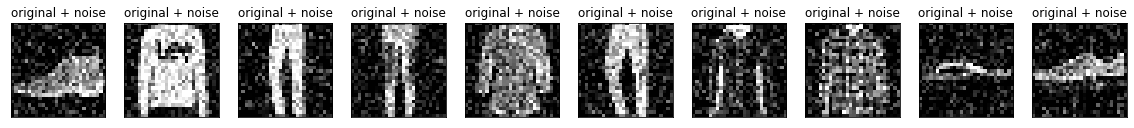

In [30]:
# Plot the noisy image
n = 10
plt.figure(figsize=(20,2))
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i+1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)    
plt.show()

In [31]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(28, 28, 1)),
            layers.Conv2D(16,(3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(8,(3, 3), activation='relu', padding='same', strides=2)])
        
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(8, kernel_size=3, activation='relu', padding='same', strides=2),
            layers.Conv2DTranspose(16, kernel_size=3, activation='relu', padding='same', strides=2),
            layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    

In [32]:
autoencoder = Denoise()

autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))
autoencoder.encoder.summary()

Epoch 1/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0128 - val_loss: 0.0125
Epoch 2/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0045 - val_loss: 0.0128
Epoch 3/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0034 - val_loss: 0.0136
Epoch 4/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0030 - val_loss: 0.0141
Epoch 5/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0029 - val_loss: 0.0142
Epoch 6/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0028 - val_loss: 0.0141
Epoch 7/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0027 - val_loss: 0.0143
Epoch 8/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0026 - val_loss: 0.0143
Epoch 9/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0026 - val_loss: 0.0145
Epoch 10/10
1875/1875 [==============================] - 18s 10ms/ste

In [19]:
autoencoder.decoder.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_10 (Conv2DT (None, 14, 14, 8)         584       
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 28, 28, 16)        1168      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 1)         145       
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


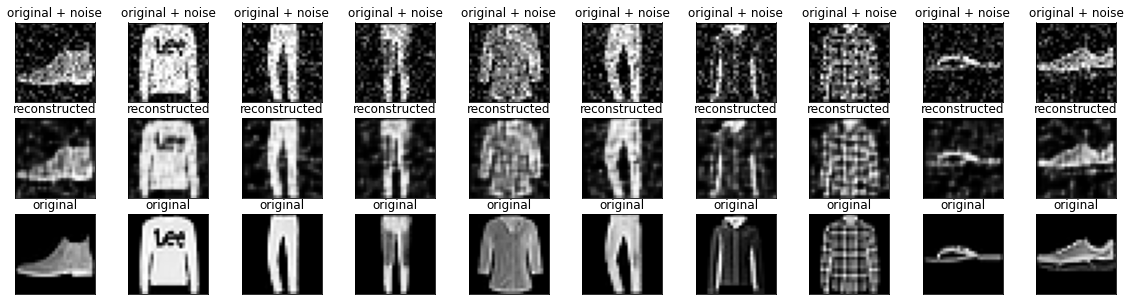

In [43]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20,5))
for i in range(n):
    # display original + noise
    ax = plt.subplot(3, n, i+1)
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.title("original + noise")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3,n,i+1+n)
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display original
    ax = plt.subplot(3,n,i+1+2*n)
    plt.imshow(tf.squeeze(x_test[i]))
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()